# BSE SENSEX Stock Price Prediction Model
---

## **Introduction**
This project implements an advanced stock price prediction model for the BSE SENSEX index, combining historical price data with sentiment analysis from news headlines. The model leverages a hybrid approach, integrating traditional technical indicators, NLP techniques, and machine learning algorithms to forecast future stock prices.

### **Key Features**
- **Data Integration**: Merging BSE SENSEX historical data (2001-2020) with Indian news headlines.
- **Sentiment Analysis**: Using VADER sentiment analysis with custom financial lexicon enhancements.
- **Feature Engineering**: Creating technical indicators like moving averages, RSI, Bollinger Bands, etc.
- **Hybrid Model Architecture**: Combining linear regression and LSTM networks for accurate predictions.
- **Performance Evaluation**: Metrics like RMSE, MAE, and R² to assess accuracy.


## **About the dataset**
The news dataset **Times of India News Headlines** is a persistent historical archive of noteable events in the Indian subcontinent from start-2001 to end-2020, recorded in realtime by the journalists of India. It contains approximately 3.4 million events published by Times of India.

Times Group as a news agency, reaches out a very wide audience across Asia and drawfs every other agency in the quantity of english articles published per day. The data can be accessed at Times of India News Headlines.

Due to the heavy daily volume over multiple years, this data offers a deep insight into Indian society, its priorities, events, issues and talking points and how they have unfolded over time. It is possible to chop this dataset into a smaller piece for a more focused analysis, based on one or more facets. 

---


## **Setting Up Environment**
---
### Library Overview
We use the following libraries:
- **Data Manipulation**:
  - `pandas` and `numpy`: For data processing and numerical operations.
  - `yfinance`: To download BSE SENSEX historical data.

- **Natural Language Processing**:
  - `nltk` with `SentimentIntensityAnalyzer`: For analyzing sentiment in news headlines.

- **Machine Learning & Deep Learning**:
  - `scikit-learn`: For preprocessing and linear regression.
  - `tensorflow/keras`: For building and training LSTM networks.

- **Visualization**:
  - `matplotlib`: For visualizing data, training progress, and predictions.
---

In [141]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("Libraries imported successfully!")

Libraries imported successfully!


## **Data Loading**
---
### Overview
In this step, we load two datasets:
1. **BSE SENSEX Historical Data**: Fetched using `yfinance` for the period from January 2001 to December 2020.
2. **Indian News Headlines Dataset**: Contains news headlines related to Indian markets.

We will inspect both datasets to understand their structure and check for missing values.

---

In [142]:
# Load datasets
print("Loading datasets...")
news_headlines = pd.read_csv("india-news-headlines.csv")

# Download BSE SENSEX data
bse_data = yf.download('^BSESN', start='2001-01-02', end='2020-12-31', actions=True)

# Inspect datasets
print("\n--- News Headlines Dataset Info ---")
print(news_headlines.info())
print("\n--- News Headlines Dataset Head ---")
print(news_headlines.head())

print("\n--- BSE SENSEX Dataset Info ---")
print(bse_data.info())
print("\n--- BSE SENSEX Dataset Head ---")
print(bse_data.head())

Loading datasets...


[*********************100%***********************]  1 of 1 completed


--- News Headlines Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 83.6+ MB
None

--- News Headlines Dataset Head ---
   publish_date headline_category  \
0      20010102           unknown   
1      20010102           unknown   
2      20010102           unknown   
3      20010102           unknown   
4      20010102           unknown   

                                       headline_text  
0  Status quo will not be disturbed at Ayodhya; s...  
1                Fissures in Hurriyat over Pak visit  
2              America's unwanted heading for India?  
3                 For bigwigs; it is destination Goa  
4               Extra buses to clear tourist traffic  

--- BSE SENSEX Dataset Info ---
<class 'pandas.co

## **Preprocessing Stock Data**
---
### Overview
We clean the BSE SENSEX data by:
- Removing duplicate entries.
- Normalizing dates to ensure consistency.
- Retaining only relevant columns (`Close`, `Open`, `High`, `Low`, `Volume`).
- Handling missing values in the `Volume` column using forward fill (`method='ffill`).

---

In [143]:
# Preprocess stock data
print("\nPreprocessing BSE SENSEX data...")
bse_data.reset_index(inplace=True)
bse_data = bse_data.drop_duplicates()
bse_data['Date'] = pd.to_datetime(bse_data['Date']).dt.normalize()
bse_data = bse_data[['Date', 'Close', 'Open', 'High', 'Low', 'Volume']]
bse_data.set_index('Date', inplace=True)

# Handle missing values in Volume column
bse_data['Volume'] = bse_data['Volume'].replace(0, np.nan).fillna(method='ffill')


print("\n--- Preprocessed BSE SENSEX Data Head ---")
print(bse_data.head())


Preprocessing BSE SENSEX data...

--- Preprocessed BSE SENSEX Data Head ---
Price             Close         Open         High          Low Volume
Ticker           ^BSESN       ^BSESN       ^BSESN       ^BSESN ^BSESN
Date                                                                 
2001-01-02  4018.879883  3953.219971  4028.570068  3929.370117    NaN
2001-01-03  4060.020020  3977.580078  4067.659912  3977.580078    NaN
2001-01-04  4115.370117  4180.970215  4180.970215  4109.549805    NaN
2001-01-05  4183.729980  4116.339844  4195.009766  4115.350098    NaN
2001-01-08  4120.430176  4164.759766  4206.720215  4101.529785    NaN


## **Preprocessing News Headlines**
---
### Overview
We clean the news headlines dataset by:
- Removing duplicate entries.
- Normalizing dates to match the format of the stock data.
- Grouping headlines by date and concatenating them into a single string per day.
---

In [144]:
# Preprocess news headlines
print("\nPreprocessing news headlines...")
news_headlines = news_headlines.drop_duplicates().reset_index()
news_headlines['publish_date'] = pd.to_datetime(
    news_headlines['publish_date'], format='%Y%m%d', errors='coerce'
).dt.normalize()
news_headlines = news_headlines.groupby('publish_date')['headline_text'].agg(' '.join)


print("\n--- Preprocessed News Headlines ---")
print(news_headlines.head())



Preprocessing news headlines...



--- Preprocessed News Headlines ---
publish_date
2001-01-02    Status quo will not be disturbed at Ayodhya; s...
2001-01-03    Powerless north India gropes in the dark Think...
2001-01-04    The string that pulled Stephen Hawking to Indi...
2001-01-05    Light combat craft takes India into club class...
2001-01-06    Light combat craft takes India into club class...
Name: headline_text, dtype: object


## **Merging Datasets**
---
### Overview
Finally, we merge the stock data and news headlines on their respective date columns. Rows with missing values after merging are dropped.

---

In [145]:
# Merge datasets on Date column
print("\nMerging datasets...")
stock_data = pd.concat([bse_data, news_headlines], axis=1).dropna()

# Fixing multi-index columns
if any(isinstance(col, tuple) for col in stock_data.columns):
    stock_data.columns = [col[0] if isinstance(col, tuple) else col for col in stock_data.columns]

print(f"\nFinal dataset shape: {stock_data.shape}")
print("\n--- Final Dataset Info ---")
print(stock_data.info())
print("\n--- Final Dataset Head ---")
print(stock_data.head())


Merging datasets...

Final dataset shape: (4298, 6)

--- Final Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4298 entries, 2003-07-14 to 2020-12-30
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Close          4298 non-null   float64
 1   Open           4298 non-null   float64
 2   High           4298 non-null   float64
 3   Low            4298 non-null   float64
 4   Volume         4298 non-null   float64
 5   headline_text  4298 non-null   object 
dtypes: float64(5), object(1)
memory usage: 235.0+ KB
None

--- Final Dataset Head ---
                  Close         Open         High          Low   Volume  \
2003-07-14  3720.750000  3704.629883  3726.560059  3704.629883  21200.0   
2003-07-15  3686.340088  3719.169922  3733.879883  3657.179932  22800.0   
2003-07-16  3721.649902  3702.139893  3729.020020  3662.699951  18400.0   
2003-07-17  3668.909912  3728.840088  3750.000000  3660.

# **Sentiment Analysis**

---

## **Overview**

In this step, we analyze the sentiment of news headlines related to the stock market using the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool. Sentiment analysis helps quantify the emotional tone of news headlines, which can influence stock price movements.

### **Goals**
1. Enhance VADER's lexicon with financial terms for improved accuracy.
2. Compute sentiment scores for each headline.
3. Normalize sentiment scores to a range of 0 to 1.
4. Generate rolling averages of sentiment to capture short-term trends.
5. Create binary sentiment indicators (e.g., bullish or very bullish).

---


## Enhancing VADER Lexicon

VADER is a pre-trained sentiment analysis tool that assigns sentiment scores to text. To improve its accuracy for financial data, we add domain-specific terms like "bullish," "bearish," "surge," and "crash" with custom weights.


In [146]:
# Import necessary libraries for sentiment analysis
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Downloading VADER lexicon
nltk.download('vader_lexicon', quiet=True)
sid = SentimentIntensityAnalyzer()

# Enhancing VADER with financial lexicon
financial_dict = {
    'bullish': 3.0, 'rally': 2.0, 'surge': 2.0, 'growth': 1.5, 'profit': 1.0,
    'bearish': -3.0, 'crash': -2.0, 'decline': -1.5, 'loss': -1.0, 'fall': -1.0
}
sid.lexicon.update(financial_dict)

print("Financial lexicon added successfully!")

Financial lexicon added successfully!


## Computing Sentiment Scores

We use VADER to compute a compound sentiment score for each headline. The compound score ranges from -1 (negative) to +1 (positive). Headlines are truncated to 5000 characters to ensure efficient processing.


In [147]:
# Define a function to compute sentiment scores
def get_financial_sentiment(text):
    if isinstance(text, str):
        return sid.polarity_scores(text[:5000])['compound']
    return 0

# Apply sentiment analysis to headlines
stock_data['sentiment'] = stock_data['headline_text'].apply(get_financial_sentiment)

print("\n--- Sentiment Scores ---")
print(stock_data[['headline_text', 'sentiment']].head())


--- Sentiment Scores ---
                                                headline_text  sentiment
2003-07-14  Hot enough or fast enough? Fat can be addictiv...    -0.9985
2003-07-15  New boat building yard to be set up in Kochi N...    -0.9919
2003-07-16  MD's fake diploma finally gets him India to se...    -0.9973
2003-07-17  Indians are unwilling to swipe their cards Sou...    -0.9967
2003-07-18  Airtel receives Govt nod for additional spectr...    -0.7564


## Normalizing Sentiment Scores

To address biases in raw sentiment scores, we normalize them to a range of 0 (most negative) to 1 (most positive). This makes the scores easier to interpret and use in predictive modeling.


In [148]:
# Normalize sentiment scores
stock_data['sentiment_norm'] = (stock_data['sentiment'] + 1) / 2

print("\n--- Normalized Sentiment Scores ---")
print(stock_data[['sentiment', 'sentiment_norm']].head())


--- Normalized Sentiment Scores ---
            sentiment  sentiment_norm
2003-07-14    -0.9985         0.00075
2003-07-15    -0.9919         0.00405
2003-07-16    -0.9973         0.00135
2003-07-17    -0.9967         0.00165
2003-07-18    -0.7564         0.12180


## Rolling Averages of Sentiment

Rolling averages help smooth out short-term fluctuations in sentiment and capture trends over time:
- **3-day average** (`sentiment_3d`): Captures very short-term trends.
- **7-day average** (`sentiment_7d`): Captures weekly trends.


In [149]:
# Compute rolling averages of sentiment
stock_data['sentiment_3d'] = stock_data['sentiment'].rolling(3, min_periods=1).mean()
stock_data['sentiment_7d'] = stock_data['sentiment'].rolling(7, min_periods=1).mean()

print("\n--- Rolling Averages of Sentiment ---")
print(stock_data[['sentiment', 'sentiment_3d', 'sentiment_7d']].head())


--- Rolling Averages of Sentiment ---
            sentiment  sentiment_3d  sentiment_7d
2003-07-14    -0.9985       -0.9985      -0.99850
2003-07-15    -0.9919       -0.9952      -0.99520
2003-07-16    -0.9973       -0.9959      -0.99590
2003-07-17    -0.9967       -0.9953      -0.99610
2003-07-18    -0.7564       -0.9168      -0.94816


## Binary Sentiment Indicators

Binary indicators simplify sentiment analysis by categorizing headlines as:
- **Bullish** (`bullish`): Headlines with a compound score > -0.3.
- **Very Bullish** (`very_bullish`): Headlines with a compound score > +0.3.
These indicators can be used as features in predictive models.


In [150]:
# Create binary sentiment indicators
stock_data['bullish'] = (stock_data['sentiment'] > -0.3).astype(int)
stock_data['very_bullish'] = (stock_data['sentiment'] > 0.3).astype(int)

# Drop headline_text column after processing
stock_data.drop('headline_text', axis=1, inplace=True)

# Display binary sentiment indicators
print("\n--- Binary Sentiment Indicators ---")
print(stock_data[['sentiment', 'bullish', 'very_bullish']].head())


--- Binary Sentiment Indicators ---
            sentiment  bullish  very_bullish
2003-07-14    -0.9985        0             0
2003-07-15    -0.9919        0             0
2003-07-16    -0.9973        0             0
2003-07-17    -0.9967        0             0
2003-07-18    -0.7564        0             0


# **Feature Engineering**

---

## **Overview**

In this step, we engineer additional features from the stock price data to improve the predictive power of our models. These features include technical indicators, price lags, volatility measures, and more. Feature engineering is crucial for capturing complex patterns in stock price movements.

### **Goals**
1. Create lagged features for historical prices and returns.
2. Compute moving averages (MA) and their ratios.
3. Calculate volatility measures.
4. Add technical indicators like RSI (Relative Strength Index) and Bollinger Bands.
5. Define the target variable (`next_close`) for prediction.

---

## Creating Lagged Features

Lagged features represent past values of stock prices and returns. These are essential for capturing historical trends and patterns:
- **`close_lag_n`**: Closing price `n` days ago.
- **`return_lag_n`**: Log return `n` days ago.


In [151]:
# Create lagged features
for i in range(1, 8):
    stock_data[f'close_lag_{i}'] = stock_data['Close'].shift(i)
    stock_data[f'return_lag_{i}'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1)).shift(i)

print("\n--- Lagged Features ---")
print(stock_data[[f'close_lag_{i}' for i in range(1, 4)] + [f'return_lag_{i}' for i in range(1, 4)]].head())



--- Lagged Features ---
            close_lag_1  close_lag_2  close_lag_3  return_lag_1  return_lag_2  \
2003-07-14          NaN          NaN          NaN           NaN           NaN   
2003-07-15  3720.750000          NaN          NaN           NaN           NaN   
2003-07-16  3686.340088  3720.750000          NaN     -0.009291           NaN   
2003-07-17  3721.649902  3686.340088  3720.750000      0.009533     -0.009291   
2003-07-18  3668.909912  3721.649902  3686.340088     -0.014273      0.009533   

            return_lag_3  
2003-07-14           NaN  
2003-07-15           NaN  
2003-07-16           NaN  
2003-07-17           NaN  
2003-07-18     -0.009291  


## Computing Moving Averages

Moving averages smooth out price fluctuations over a specified period:
- **`ma_n`**: Moving average over `n` days.
- **Ratios**:
  - `ma5_10_ratio`: Ratio of 5-day to 10-day moving averages.
  - `ma10_20_ratio`: Ratio of 10-day to 20-day moving averages.


In [152]:
# Compute moving averages
stock_data['ma5'] = stock_data['Close'].rolling(5).mean()
stock_data['ma10'] = stock_data['Close'].rolling(10).mean()
stock_data['ma20'] = stock_data['Close'].rolling(20).mean()
stock_data['ma50'] = stock_data['Close'].rolling(50).mean()

# Compute moving average ratios
stock_data['close_ma5_pct'] = (stock_data['Close'] - stock_data['ma5']) / stock_data['ma5'] * 100
stock_data['ma5_10_ratio'] = stock_data['ma5'] / stock_data['ma10']
stock_data['ma10_20_ratio'] = stock_data['ma10'] / stock_data['ma20']
stock_data['log_return'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))

print("\n--- Moving Averages and Ratios ---")
print(stock_data[['ma5', 'ma10', 'ma20', 'ma50', 'ma5_10_ratio', 'ma10_20_ratio']].head())



--- Moving Averages and Ratios ---
                    ma5  ma10  ma20  ma50  ma5_10_ratio  ma10_20_ratio
2003-07-14          NaN   NaN   NaN   NaN           NaN            NaN
2003-07-15          NaN   NaN   NaN   NaN           NaN            NaN
2003-07-16          NaN   NaN   NaN   NaN           NaN            NaN
2003-07-17          NaN   NaN   NaN   NaN           NaN            NaN
2003-07-18  3689.045996   NaN   NaN   NaN           NaN            NaN


## Calculating Volatility

Volatility measures the dispersion of returns over a given period:
- **`volatility_n`**: Standard deviation of log returns over `n` days.


In [153]:
# Compute volatility measures
stock_data['volatility_5d'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1)).rolling(5).std()
stock_data['volatility_10d'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1)).rolling(10).std()

print("\n--- Volatility Measures ---")
print(stock_data[['volatility_5d', 'volatility_10d']].head())


--- Volatility Measures ---
            volatility_5d  volatility_10d
2003-07-14            NaN             NaN
2003-07-15            NaN             NaN
2003-07-16            NaN             NaN
2003-07-17            NaN             NaN
2003-07-18            NaN             NaN


## Adding RSI (Relative Strength Index)

RSI is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions:
- RSI values range from 0 to 100.
- Computed using gains and losses over a rolling window (14 days).


In [154]:
# Compute RSI (Relative Strength Index)
delta = stock_data['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
rs = gain / loss.replace(0, np.nan).fillna(gain)
stock_data['rsi_14'] = 100 - (100 / (1 + rs))

# Display RSI values
print("\n--- RSI Values ---")
print(stock_data[['rsi_14']].head())


--- RSI Values ---
            rsi_14
2003-07-14     NaN
2003-07-15     NaN
2003-07-16     NaN
2003-07-17     NaN
2003-07-18     NaN


## Adding Bollinger Bands

Bollinger Bands are a volatility-based indicator consisting of:
- **Middle Band (`bb_middle`)**: 20-day moving average.
- **Upper Band (`bb_upper`)** and Lower Band (`bb_lower`) based on standard deviations from the middle band.
- **Band Width (`bb_width`)**: Difference between upper and lower bands as a percentage of the middle band.
- **Position (`bb_position`)**: Current price's position within the bands (scaled between 0 and 1).


In [155]:
# Compute Bollinger Bands
stock_data['bb_middle'] = stock_data['Close'].rolling(20).mean()
stock_data['bb_std'] = stock_data['Close'].rolling(20).std()
stock_data['bb_upper'] = stock_data['bb_middle'] + (2 * stock_data['bb_std'])
stock_data['bb_lower'] = stock_data['bb_middle'] - (2 * stock_data['bb_std'])
stock_data['bb_width'] = (stock_data['bb_upper'] - stock_data['bb_lower']) / stock_data['bb_middle']
stock_data['bb_position'] = ((stock_data['Close'] - stock_data['bb_lower']) /
                             (stock_data['bb_upper'] - stock_data['bb_lower'])).clip(0, 1)

# Display Bollinger Bands
print("\n--- Bollinger Bands ---")
print(stock_data[['bb_middle', 'bb_upper', 'bb_lower', 'bb_width', 'bb_position']].head())



--- Bollinger Bands ---
            bb_middle  bb_upper  bb_lower  bb_width  bb_position
2003-07-14        NaN       NaN       NaN       NaN          NaN
2003-07-15        NaN       NaN       NaN       NaN          NaN
2003-07-16        NaN       NaN       NaN       NaN          NaN
2003-07-17        NaN       NaN       NaN       NaN          NaN
2003-07-18        NaN       NaN       NaN       NaN          NaN


## Defining Target Variable

The target variable (`next_close`) represents the closing price on the next trading day. This is what our model will predict.


In [156]:
# Define target variable
stock_data['next_close'] = stock_data['Close'].shift(-1)

# Drop rows with NaN values caused by lagging or shifting operations
stock_data.dropna(inplace=True)

# Display target variable
print("\n--- Target Variable ---")
print(stock_data[['Close', 'next_close']].head())


--- Target Variable ---
                  Close   next_close
2003-09-22  4151.720215  4231.689941
2003-09-23  4231.689941  4356.390137
2003-09-24  4356.390137  4297.149902
2003-09-25  4297.149902  4382.569824
2003-09-26  4382.569824  4402.049805


# **Data Preparation for Modeling**

---

## **Overview**

In this step, we prepare the engineered dataset for machine learning and deep learning models. This involves:
1. Selecting relevant features for training.
2. Splitting the data into training and testing sets.
3. Scaling the features and target variable to improve model performance.
4. Reshaping the data for LSTM (Long Short-Term Memory) networks.

---



## Feature Selection

We select the most relevant features for training the model. These include:
- **Lagged Features**: `close_lag_n`, `return_lag_n`.
- **Technical Indicators**: Moving averages, RSI, Bollinger Bands, etc.
- **Sentiment Features**: Normalized sentiment scores and binary indicators.

The target variable is `next_close`, which represents the closing price on the next trading day.


In [157]:
# Select relevant features
selected_features = [
    'close_lag_1', 'close_lag_2', 'ma5', 'ma20', 'ma5_10_ratio',
    'close_ma5_pct', 'volatility_5d', 'rsi_14', 'bb_position',
    'log_return', 'return_lag_1', 'sentiment_norm', 'bullish'
]

X = stock_data[selected_features]
y = stock_data['next_close']

print("\n--- Selected Features ---")
print(X.head())
print("\n--- Target Variable ---")
print(y.head())


--- Selected Features ---
            close_lag_1  close_lag_2          ma5         ma20  ma5_10_ratio  \
2003-09-22  4217.120117  4134.149902  4202.618066  4280.806006      0.982714   
2003-09-23  4151.720215  4217.120117  4194.006055  4284.776001      0.985158   
2003-09-24  4231.689941  4151.720215  4218.214063  4292.317505      0.992660   
2003-09-25  4356.390137  4231.689941  4250.814062  4296.560498      1.002596   
2003-09-26  4297.149902  4356.390137  4283.904004  4303.452490      1.008577   

            close_ma5_pct  volatility_5d     rsi_14  bb_position  log_return  \
2003-09-22      -1.211099       0.020339  39.419860     0.164518   -0.015630   
2003-09-23       0.898518       0.020330  48.516461     0.356003    0.019079   
2003-09-24       3.275701       0.023836  52.397496     0.675041    0.029042   
2003-09-25       1.090046       0.020827  46.238847     0.501645   -0.013692   
2003-09-26       2.303175       0.020799  47.357214     0.718195    0.019683   

           

## Splitting Data into Training and Testing Sets

We split the data into:
- **Training Set**: 80% of the data, used to train the model.
- **Testing Set**: 20% of the data, used to evaluate model performance.

This ensures that the model is evaluated on unseen data to avoid overfitting.


In [158]:
# Split data into training and testing sets (80-20 split)
split_idx = int(len(stock_data) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("\n--- Training Set Shape ---")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print("\n--- Testing Set Shape ---")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


--- Training Set Shape ---
X_train: (3398, 13), y_train: (3398,)

--- Testing Set Shape ---
X_test: (850, 13), y_test: (850,)


## Scaling Features and Target Variable

Scaling ensures that all features are on a similar scale, which improves model performance:
- We use `MinMaxScaler` to scale features to a range of -1 to 1.
- The target variable (`next_close`) is also scaled to match the feature scaling.


In [159]:
# Initialize scalers for features and target variable
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

# Scale training and testing features
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Scale training and testing target variable
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

# Display scaled data samples
print("\n--- Scaled Training Features (Sample) ---")
print(X_train_scaled[:5])
print("\n--- Scaled Training Target (Sample) ---")
print(y_train_scaled[:5])


--- Scaled Training Features (Sample) ---
[[-0.99526998 -1.         -0.99937456 -1.         -0.29793251 -0.16890828
  -0.51926935 -0.27200808 -0.67096324 -0.26284064 -0.0074341  -0.99949972
  -1.        ]
 [-1.         -0.99399048 -1.         -0.99970599 -0.26519543 -0.00950376
  -0.51948076 -0.07926614 -0.28799353 -0.0131326  -0.26284064 -0.99819901
  -1.        ]
 [-0.99421622 -0.99872739 -0.99824192 -0.99914749 -0.16470529  0.17011835
  -0.43172914  0.00296657  0.35008204  0.05855063 -0.0131326  -0.99879934
  -1.        ]
 [-0.98519733 -0.99293519 -0.99587438 -0.99883326 -0.03161033  0.00496831
  -0.5070564  -0.12752502  0.00329087 -0.2488983   0.05855063 -0.99809895
  -1.        ]
 [-0.98948185 -0.98390318 -0.99347125 -0.99832286  0.04850473  0.09663344
  -0.50773613 -0.10382868  0.43638952 -0.00878274 -0.2488983  -0.88793837
  -1.        ]]

--- Scaled Training Target (Sample) ---
[[-1.        ]
 [-0.9910306 ]
 [-0.99529161]
 [-0.98914755]
 [-0.9877464 ]]


## Reshaping Data for LSTM

LSTM networks expect input data in a 3D format:
- Shape: `(samples, timesteps, features)`.
- We reshape the scaled feature data to include a single timestep.


In [160]:
# Reshape feature data for LSTM input (3D format)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

print("\n--- Reshaped Data for LSTM ---")
print(f"X_train_reshaped shape: {X_train_reshaped.shape}")
print(f"X_test_reshaped shape: {X_test_reshaped.shape}")


--- Reshaped Data for LSTM ---
X_train_reshaped shape: (3398, 13, 1)
X_test_reshaped shape: (850, 13, 1)


# **Model Training and Prediction**

---

## **Overview**

In this step, we train two models to predict stock prices:
1. **Linear Regression Model**: Captures linear trends in the data.
2. **LSTM Model**: Captures complex temporal patterns using deep learning.

Additionally, we create an **ensemble prediction** by combining the outputs of both models for improved accuracy.

---

## Training the Linear Regression Model

Linear regression is a simple yet effective model for capturing linear relationships between features and the target variable. We train it using the scaled feature and target data.


In [161]:
# Create data_tuple to store training and testing data and their scaled versions
data_tuple = (X_train, X_test, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, X_train_reshaped, X_test_reshaped, y_train, y_test)

# Train the Linear Regression model
def train_linear_model(X_train_scaled, y_train_scaled):
    print("Training Linear Regression model...")
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train_scaled)
    return lr_model

# Train the model
lr_model = train_linear_model(data_tuple[2], data_tuple[4])  # Use correct indices from data_tuple

# Display coefficients of the linear regression model
print("\n--- Linear Regression Coefficients ---")
print(pd.DataFrame({
    'Feature': [
        'close_lag_1', 'close_lag_2', 'ma5', 'ma20', 'ma5_10_ratio',
        'close_ma5_pct', 'volatility_5d', 'rsi_14', 'bb_position',
        'log_return', 'return_lag_1', 'sentiment_norm', 'bullish'
    ],
    'Coefficient': lr_model.coef_[0]
}))

Training Linear Regression model...

--- Linear Regression Coefficients ---
           Feature  Coefficient
0      close_lag_1     0.614284
1      close_lag_2    -0.648654
2              ma5     1.036583
3             ma20    -0.009930
4     ma5_10_ratio    -0.014570
5    close_ma5_pct     0.122793
6    volatility_5d     0.001348
7           rsi_14    -0.006051
8      bb_position     0.009602
9       log_return     0.006166
10    return_lag_1    -0.095975
11  sentiment_norm     0.004574
12         bullish    -0.004727


## Building the LSTM Model

LSTM (Long Short-Term Memory) networks are specialized for sequential data like stock prices. They can capture temporal dependencies and complex patterns over time.

### Architecture:
- **Bidirectional LSTM**: Captures dependencies in both forward and backward directions.
- **Dropout Layers**: Prevent overfitting.
- **Dense Layers**: Map learned features to predictions.


In [162]:
# Build LSTM model
def build_lstm_model(input_shape):
    print("Building LSTM model...")
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True, input_shape=input_shape,
                          kernel_regularizer=tf.keras.regularizers.l2(0.001))),
        Dropout(0.35),
        LSTM(64, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.25),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
        loss='mse',
        metrics=['mae']
    )

    return model

# Build the LSTM model with the correct input shape
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
lstm_model = build_lstm_model(input_shape)

print(lstm_model.summary())

Building LSTM model...


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_13                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


## Training the LSTM Model

We train the LSTM model using:
- **Early Stopping**: Stops training when validation loss stops improving.
- **Learning Rate Reduction**: Reduces learning rate if validation loss stagnates.

The training process involves multiple epochs with a batch size of 32.


In [163]:
# Train the LSTM model
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

print("\n--- Shapes of Input Data for LSTM ---")
print(f"X_train_reshaped shape: {X_train_reshaped.shape}")
print(f"y_train_scaled shape: {y_train_scaled.shape}")

history = lstm_model.fit(
    X_train_reshaped,
    y_train_scaled,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


--- Shapes of Input Data for LSTM ---
X_train_reshaped shape: (3398, 13, 1)
y_train_scaled shape: (3398, 1)
Epoch 1/150


85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 0.2405 - mae: 0.1772 - val_loss: 0.0675 - val_mae: 0.1420 - learning_rate: 0.0010
Epoch 2/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0376 - mae: 0.0470 - val_loss: 0.0349 - val_mae: 0.1295 - learning_rate: 0.0010
Epoch 3/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0165 - mae: 0.0425 - val_loss: 0.0155 - val_mae: 0.0754 - learning_rate: 0.0010
Epoch 4/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0100 - mae: 0.0395 - val_loss: 0.0092 - val_mae: 0.0598 - learning_rate: 0.0010
Epoch 5/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0080 - mae: 0.0461 - val_loss: 0.0145 - val_mae: 0.0965 - learning_rate: 0.0010
Epoch 6/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0053 - mae: 0.0357 - val_loss: 0.0040 - val_mae: 0.0316 - learning_rate: 0.0010
Epoch 7/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0047 - mae: 0.0385 - val_loss: 0.0031 - val_mae: 0.0281 - learning_rate: 0.0010
Epoch 8/150
85/85

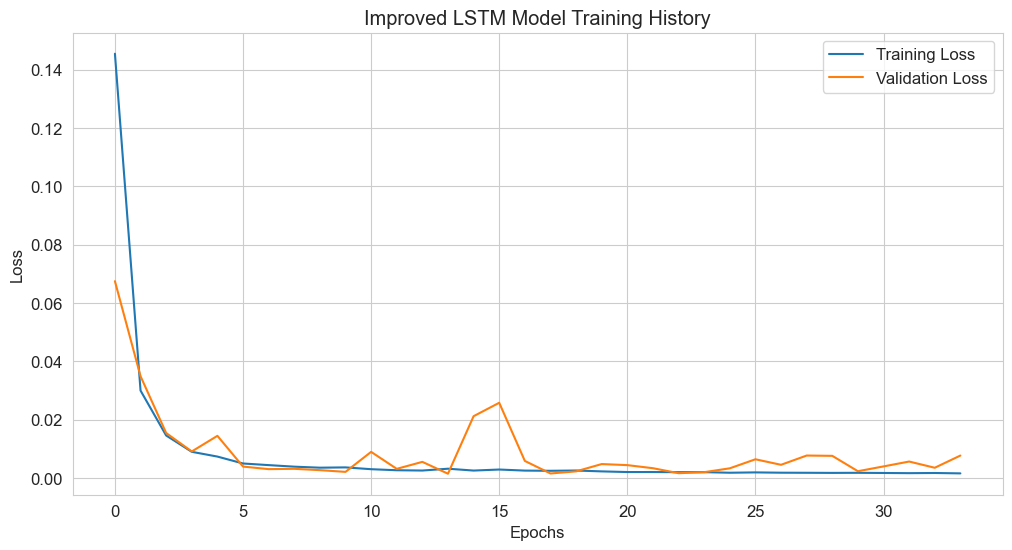

In [164]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Improved LSTM Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Making Predictions**

---

## **Overview**

Now that the models are trained, we will use them to make predictions on the test set and evaluate their performance. We will:
1. Generate predictions using the **Linear Regression model**.
2. Generate predictions using the **LSTM model**.
3. Create an **ensemble prediction** by combining the outputs of both models.
4. Compare predictions with actual values and calculate error metrics.

---


## Linear Regression Predictions

The Linear Regression model predicts stock prices based on linear relationships between features and the target variable. We use the scaled test features to generate predictions, which are then inverse-transformed to their original scale for comparison.


In [165]:
# Generate predictions from Linear Regression model
lr_pred_scaled = lr_model.predict(X_test_scaled)
lr_pred = y_scaler.inverse_transform(lr_pred_scaled.reshape(-1, 1))

print("\n--- Linear Regression Predictions (Sample) ---")
print(lr_pred[:5])


--- Linear Regression Predictions (Sample) ---
[[32093.96482743]
 [32027.04608015]
 [31852.8677927 ]
 [31879.0513473 ]
 [32036.75093217]]


## LSTM Predictions

The LSTM model predicts stock prices by capturing complex temporal patterns in sequential data. We use the reshaped test features to generate predictions, which are then inverse-transformed to their original scale for comparison.


In [166]:
# Generate predictions from LSTM model
lstm_pred_scaled = lstm_model.predict(X_test_reshaped)
lstm_pred = y_scaler.inverse_transform(lstm_pred_scaled)

print("\n--- LSTM Predictions (Sample) ---")
print(lstm_pred[:5])

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step

--- LSTM Predictions (Sample) ---
[[31118.326]
 [31153.365]
 [31075.305]
 [31034.656]
 [30978.887]]


## Ensemble Predictions

We create an ensemble prediction by combining the outputs of both models. This approach leverages the strengths of both models:
- **Linear Regression** provides stable trend-based predictions.
- **LSTM** captures complex temporal dependencies.

The ensemble prediction is a weighted average of both models' outputs, with weights adjusted based on their performance.


In [167]:
# Create ensemble prediction (weighted average)
ensemble_pred_scaled = 0.7 * lr_pred_scaled.reshape(-1, 1) + 0.3 * lstm_pred_scaled
ensemble_pred = y_scaler.inverse_transform(ensemble_pred_scaled)

print("\n--- Ensemble Predictions (Sample) ---")
print(ensemble_pred[:5])


--- Ensemble Predictions (Sample) ---
[[31801.27333459]
 [31764.94235761]
 [31619.59881015]
 [31625.7329437 ]
 [31719.39213606]]


## Comparing Predictions

We compare the actual stock prices with predictions from:
1. **Linear Regression Model**
2. **LSTM Model**
3. **Ensemble Prediction**

This allows us to evaluate how well each approach performs on unseen data.


In [168]:
# Display sample predictions
print("\n--- Ensemble Predictions (Sample) ---")
print(ensemble_pred[:5])

# Display sample comparisons
comparison_df = pd.DataFrame({
    'Actual': y_test.values[:10].reshape(-1),
    'Linear Regression': lr_pred[:10].reshape(-1),
    'LSTM': lstm_pred[:10].reshape(-1),
    'Ensemble': ensemble_pred[:10].reshape(-1)
})
print("\n--- Sample Predictions Comparison ---")
print(comparison_df)


--- Ensemble Predictions (Sample) ---
[[31801.27333459]
 [31764.94235761]
 [31619.59881015]
 [31625.7329437 ]
 [31719.39213606]]

--- Sample Predictions Comparison ---
         Actual  Linear Regression          LSTM      Ensemble
0  32074.779297       32093.964827  31118.326172  31801.273335
1  31710.990234       32027.046080  31153.365234  31764.942358
2  31955.349609       31852.867793  31075.304688  31619.598810
3  31904.400391       31879.051347  31034.656250  31625.732944
4  32028.890625       32036.750932  30978.886719  31719.392136
5  32245.869141       32010.388813  31007.476562  31709.515430
6  32228.269531       32211.810356  31095.242188  31876.840389
7  32382.460938       32251.600061  31437.027344  32007.228766
8  32383.300781       32274.070675  31491.423828  32039.276862
9  32309.880859       32405.180274  31287.568359  32069.897013


## Calculating Error Metrics

To evaluate model performance, we calculate:
- **Mean Absolute Error (MAE)**: Average absolute difference between actual and predicted values.
- **Root Mean Squared Error (RMSE)**: Square root of average squared differences between actual and predicted values.

These metrics help quantify prediction accuracy for each approach.


In [169]:
# Calculate error metrics for each approach
print("\n--- Error Metrics ---")

mae_lr = metrics.mean_absolute_error(y_test.values, lr_pred)
rmse_lr = np.sqrt(metrics.mean_squared_error(y_test.values, lr_pred))
print(f"Linear Regression - MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}")

mae_lstm = metrics.mean_absolute_error(y_test.values, lstm_pred)
rmse_lstm = np.sqrt(metrics.mean_squared_error(y_test.values, lstm_pred))
print(f"LSTM - MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}")

mae_ensemble = metrics.mean_absolute_error(y_test.values, ensemble_pred)
rmse_ensemble = np.sqrt(metrics.mean_squared_error(y_test.values, ensemble_pred))
print(f"Ensemble - MAE: {mae_ensemble:.2f}, RMSE: {rmse_ensemble:.2f}")



--- Error Metrics ---
Linear Regression - MAE: 323.21, RMSE: 484.72
LSTM - MAE: 2861.64, RMSE: 3276.44
Ensemble - MAE: 920.70, RMSE: 1092.83


# **Model Evaluation**

---

## **Overview**

In this step, we evaluate the performance of our models (Linear Regression, LSTM, and Ensemble) using various metrics:
1. **Mean Squared Error (MSE)**: Measures the average squared difference between actual and predicted values.
2. **Root Mean Squared Error (RMSE)**: Square root of MSE, providing error in the same units as the target variable.
3. **Mean Absolute Error (MAE)**: Measures the average absolute difference between actual and predicted values.
4. **Mean Absolute Percentage Error (MAPE)**: Measures the percentage error between actual and predicted values.
5. **R² Score**: Indicates how well the model explains variance in the data.

We will also visualize the predictions against actual stock prices for better interpretability.

---



## Evaluating Models Using Metrics

We calculate the following metrics for each model:
- **Mean Squared Error (MSE)**
- **Root Mean Squared Error (RMSE)**
- **Mean Absolute Error (MAE)**
- **Mean Absolute Percentage Error (MAPE)**
- **R² Score**

These metrics provide a comprehensive view of model performance.


In [170]:
# Evaluate models using metrics like RMSE, MAE, and R²
def evaluate_models(y_test, lr_pred, lstm_pred, ensemble_pred):
    # Convert y_test to numpy array if it's a pandas Series
    if hasattr(y_test, 'values'):
        test_actual = y_test.values.reshape(-1, 1)
    else:
        test_actual = y_test.reshape(-1, 1)

    # Calculate metrics for each approach
    results = {}
    for name, predictions in [
        ("Linear Model", lr_pred),
        ("LSTM Model", lstm_pred),
        ("Ensemble Model", ensemble_pred)
    ]:
        mse = metrics.mean_squared_error(test_actual, predictions)
        rmse = np.sqrt(mse)
        mae = metrics.mean_absolute_error(test_actual, predictions)
        mape = np.mean(np.abs((test_actual - predictions) / test_actual)) * 100
        r2 = metrics.r2_score(test_actual, predictions)

        results[name] = {
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "MAPE": mape,
            "R²": r2
        }

    return results

# Evaluate models (using y_test from data_tuple[9])
results = evaluate_models(data_tuple[9], lr_pred, lstm_pred, ensemble_pred)

print("\n--- Model Evaluation Results ---")
for model_name, met in results.items():
    print(f"\n{model_name}:")
    for metric_name, value in met.items():
        print(f"{metric_name}: {value:.4f}")


--- Model Evaluation Results ---

Linear Model:
MSE: 234953.6350
RMSE: 484.7202
MAE: 323.2133
MAPE: 0.9068
R²: 0.9805

LSTM Model:
MSE: 10735069.1984
RMSE: 3276.4415
MAE: 2861.6417
MAPE: 7.5099
R²: 0.1100

Ensemble Model:
MSE: 1194268.3846
RMSE: 1092.8259
MAE: 920.7000
MAPE: 2.4408
R²: 0.9010


## Visualizing Predictions

We plot the actual stock prices against predictions from:
1. Linear Regression Model
2. LSTM Model
3. Ensemble Prediction

This helps us visually compare the accuracy of each model.


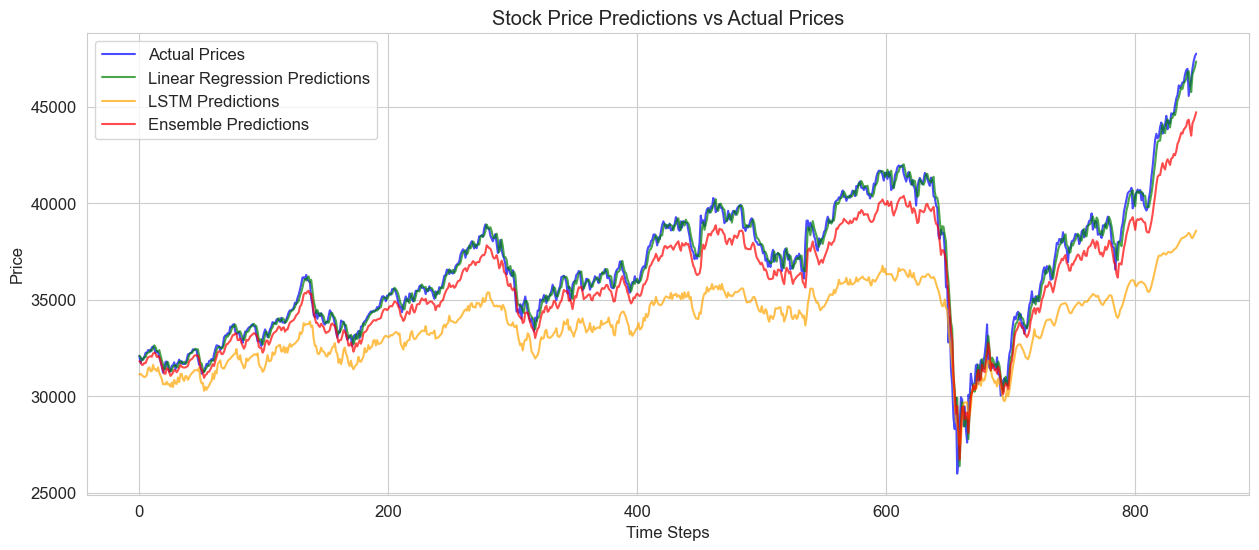

In [171]:
# Plot actual vs predicted prices (Original Ensemble)
plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label='Actual Prices', color='blue', alpha=0.7)
plt.plot(lr_pred.reshape(-1), label='Linear Regression Predictions', color='green', alpha=0.7)
plt.plot(lstm_pred.reshape(-1), label='LSTM Predictions', color='orange', alpha=0.7)
plt.plot(ensemble_pred.reshape(-1), label='Ensemble Predictions', color='red', alpha=0.7)
plt.title('Stock Price Predictions vs Actual Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()


--- Training Stacking Hybrid Model ---
 94/107 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

--- Stacking Hybrid Model Predictions (Sample) ---
[[32073.21813067]
 [32008.75862913]
 [31836.86754586]
 [31861.43413545]
 [32013.98973339]]


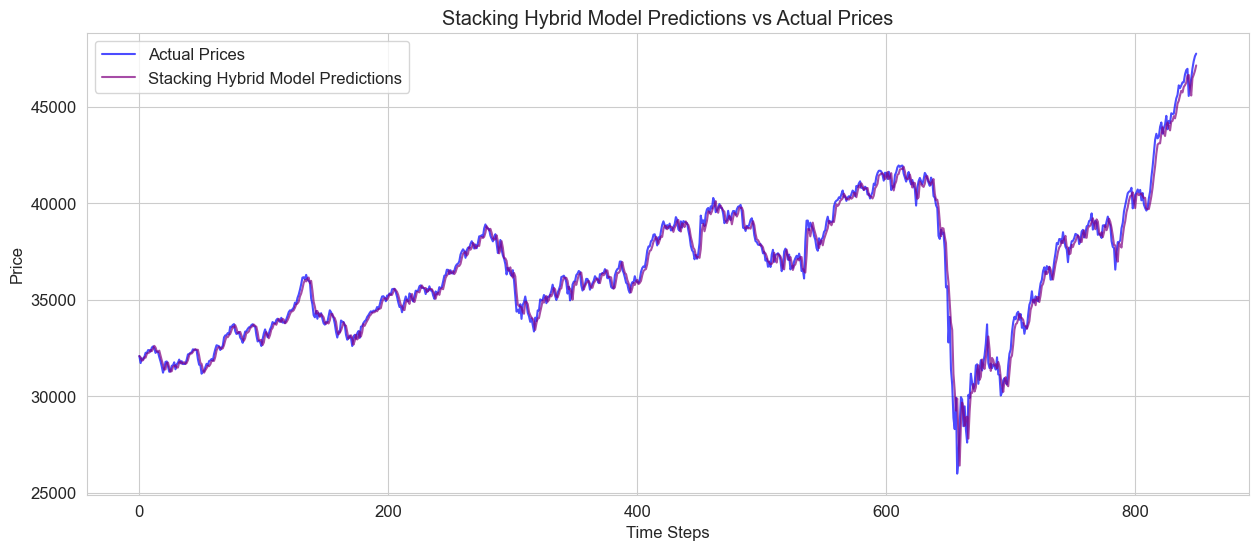

In [172]:
# ----------------------- Additional Hybrid Model (Stacking Ensemble) -----------------------
print("\n--- Training Stacking Hybrid Model ---")
# Generate predictions on training data for stacking
lr_pred_train_scaled = lr_model.predict(X_train_scaled)
lstm_pred_train_scaled = lstm_model.predict(X_train_reshaped)
# Inverse transform to get original scale
lr_pred_train = y_scaler.inverse_transform(lr_pred_train_scaled.reshape(-1,1))
lstm_pred_train = y_scaler.inverse_transform(lstm_pred_train_scaled)

# Stack predictions as features for training meta model
stacked_train = np.hstack((lr_pred_train, lstm_pred_train))

# Train meta learner (using Linear Regression as a meta-model)
meta_model = LinearRegression()
meta_model.fit(stacked_train, y_train.values.reshape(-1,1))

# Generate predictions on test data for stacking
lr_pred_test_scaled = lr_model.predict(X_test_scaled)
lstm_pred_test_scaled = lstm_model.predict(X_test_reshaped)
lr_pred_test = y_scaler.inverse_transform(lr_pred_test_scaled.reshape(-1,1))
lstm_pred_test = y_scaler.inverse_transform(lstm_pred_test_scaled)
stacked_test = np.hstack((lr_pred_test, lstm_pred_test))
hybrid2_pred = meta_model.predict(stacked_test)

# Display sample predictions for stacking ensemble
print("\n--- Stacking Hybrid Model Predictions (Sample) ---")
print(hybrid2_pred[:5])

# Plot actual vs predicted prices for stacking hybrid model
plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label='Actual Prices', color='blue', alpha=0.7)
plt.plot(hybrid2_pred.reshape(-1), label='Stacking Hybrid Model Predictions', color='purple', alpha=0.7)
plt.title('Stacking Hybrid Model Predictions vs Actual Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()